In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

In [2]:
# plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

## Standard example

### Sample data

This generates some random data sampled from a normal distribution.

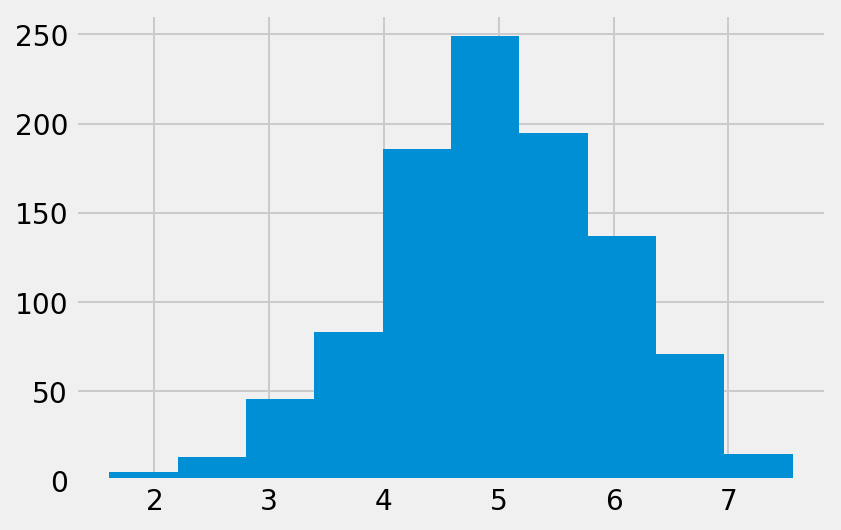

In [3]:
data = np.random.normal(loc=5.0, size=1_000)
plt.hist(data, bins=10)
plt.show()

### Fit with `pymc3`

For this toy model, let's fit a normal model with uniform priors to see if we get back what we expect:

In [4]:
with pm.Model() as model:
    mu = pm.Uniform("mu", lower=0.0, upper=10.0)
    sigma = pm.Uniform("sigma", lower=0.0, upper=2.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=data)

with model:
    trace = pm.sample(1_000, chains=4, tune=1_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2392.60draws/s]


The traces show that things seem ok.

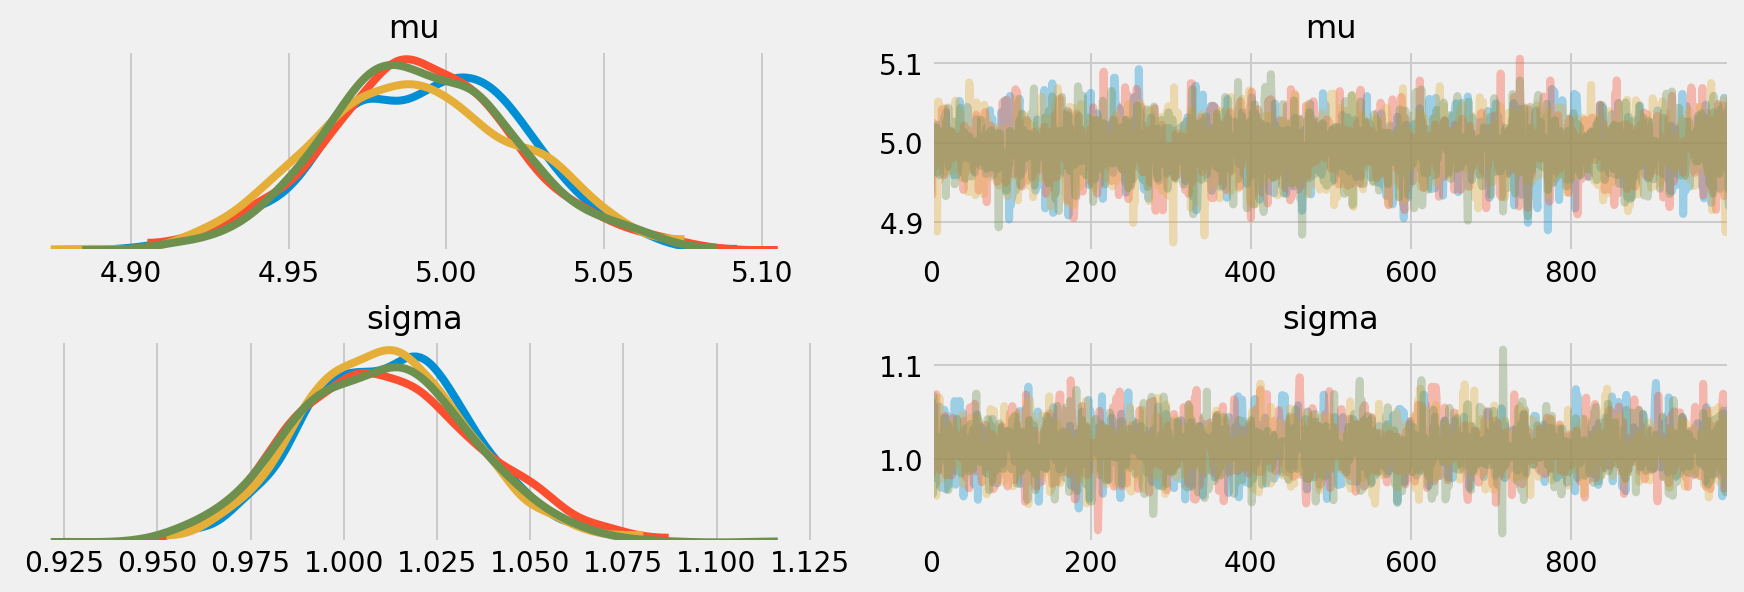

In [5]:
pm.traceplot(trace)
plt.show()

$\newcommand{\rhat}{\hat R}$
Let's check if our implementation of the standard and split-$\rhat$ agree with the one baked into `pymc3`.

In [6]:
def rhat(trace, param, split=True):
    if isinstance(trace, pm.backends.base.MultiTrace):
        # separate chains
        theta = np.array(trace.get_values(param, combine=False))
    elif isinstance(trace, np.ndarray):
        theta = trace
    else:
        raise Exception("Trace must by pymc3 object or ndarray")
    
    if split: # split chains in half
        theta = np.r_[tuple(np.hsplit(theta, 2))]
    
    M = theta.shape[0] # number of chains
    N = theta.shape[1] # number of samples per chain

    # between-chain variance (eq. 1)
    theta_hat_dotm = lambda m, N=N: (1./N)*np.sum(theta[m])
    theta_hat_ddot = (1./M)*np.sum(np.mean(theta, axis=1))
    theta_hat_diff = [theta_hat_dotm(m) - theta_hat_ddot for m in range(M)]
    B = (N/(M - 1.))*np.sum((np.array(theta_hat_diff))**2)

    # within-chain variance (eq. 2)
    theta_diff = lambda m: theta[m] - np.mean(theta[m])
    s_m_sq = lambda m, N=N: (1./(N - 1.))*np.sum(theta_diff(m)**2)
    W = (1./M)*np.sum([s_m_sq(m, N=N) for m in range(M)])

    # marginal posterior variance estimate (eq. 3)
    post_var = ((N - 1.)/N)*W + (1./N)*B

    # rhat (eq. 4)
    return np.sqrt(post_var / W)

# compare to pymc3
params = ["mu", "sigma"]
for param in params:
    rhat_calc = rhat(trace, param, split=False)
    rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
    print(f"{param}: {rhat_calc == rhat_pymc}")

mu: False
sigma: True


It looks like `pymc3` is using the standard definition for $\rhat$, which has since been outdated by the split-$\rhat$ method. Let's check that next.

In [7]:
# compare to pymc3
params = ["mu", "sigma"]
for param in params:
    rhat_calc = rhat(trace, param, split=True)
    rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
    print(param) 
    print(f"calc: {rhat_calc}")
    print(f"pymc: {rhat_pymc}\n")

mu
calc: 1.0004289037143328
pymc: 1.000399823887262

sigma
calc: 1.0000877445041456
pymc: 1.0004590169033833



We can see here that the split-$\rhat$ method can actually differ from the standard definition, even for a basic case like this. Let's test what happens if one of our chains happens to start in a different place in the parameter space.

## Shifted example

Using the same chains from the previous examples, let's simulate the first one starting in a different place by artificially shifting it by some value $c$.

In [8]:
c = 0.003
params = ["mu", "sigma"]
for param in params:
    trace_shifted_array = np.array(trace.get_values(param, combine=False)) 
    trace_shifted_array[0, :] += c
    rhat_calc = rhat(trace_shifted_array, param, split=True)
    rhat_pymc = pm.diagnostics.gelman_rubin(trace)[param]
    print(param) 
    print(f"calc: {rhat_calc}")
    print(f"pymc: {rhat_pymc}\n")

mu
calc: 1.0029289269386634
pymc: 1.000399823887262

sigma
calc: 1.003590796942549
pymc: 1.0004590169033833



This slight shift caused a noticeable change in split-$\rhat$, while the standard $\rhat$ would make us think that the chains have actually converged. This is especially dangerous if we look at the trace plot.

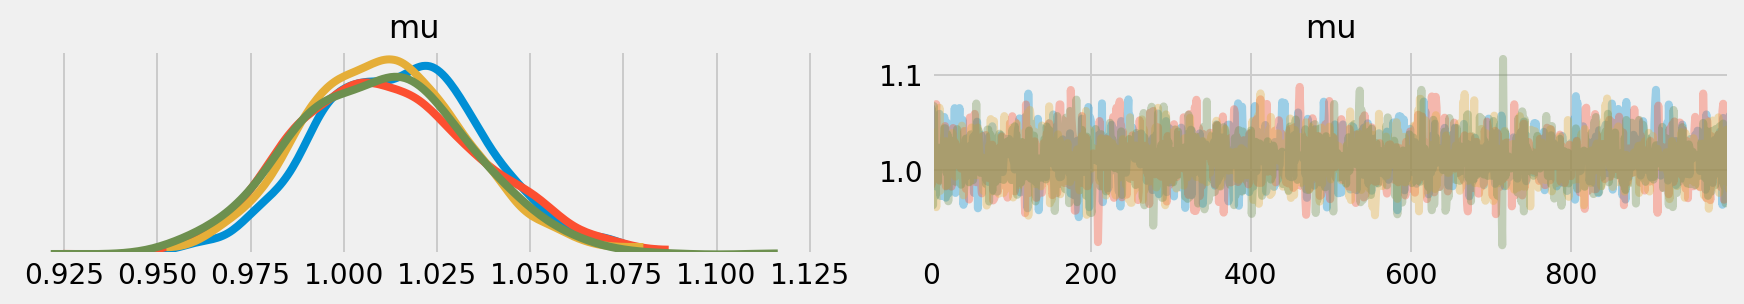

In [9]:
trace_shifted = {"mu":trace_shifted_array}
pm.traceplot(trace_shifted)
plt.show()

By eye, the chains look well mixed and the shifted chain (blue) looks visually indistinguishable from the other chains. If we were just relying on this standard trace plot or $\rhat$ definition, we would come to the misleading conclusion that our simulation has converged for this basic toy model.